In [1]:
import theano
from theano import tensor as T
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
x = T.dscalar('x')
y = T.dscalar('y')

In [170]:
# assume centered classes
num = (x*y) - 2*0*0
den = (x**2 + y**2) - 2*0*0
kappa = num/den

In [171]:
grad = T.grad(kappa,x)
grad

Elemwise{add,no_inplace}.0

In [172]:
gt = 2
xs = np.linspace(0, 10, num=50)
ys = []
for elem in xs:
    ys.append( float(grad.eval({x:elem, y:gt})) )

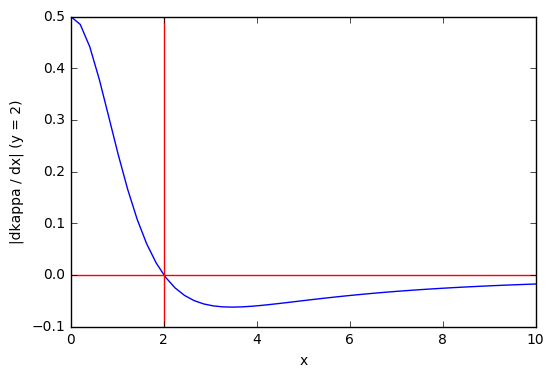

In [173]:
plt.plot(xs, ys, "b-", [0,10], [0,0], "r-", [gt,gt], [-0.1,0.5], "r-")
plt.xlabel('x')
plt.ylabel('|dkappa / dx| (y = %i)' % gt)
plt.savefig('/tmp/grads.pdf')

Comment: maybe this makes sense. Basically, we omitted the centering term $-2N\mu_{x}\mu_{y}$. Suppose $\mu_{x} = \mu_{y} = 0$, this means the mean prediction and mean ground truths are zero, so predicting them would be the 'random classifier', since this simply predicts the mean class.

However: 
* if the gt is 2, then why does a predicted x of -2 also get 0 error?
* **why does the error asymptote to 0 as you get further away from 0??**

---

In [176]:
gt = 1
xs = np.linspace(0, 10, num=50)
ys = []
for elem in xs:
    ys.append( float(kappa.eval({x:elem, y:gt})) )

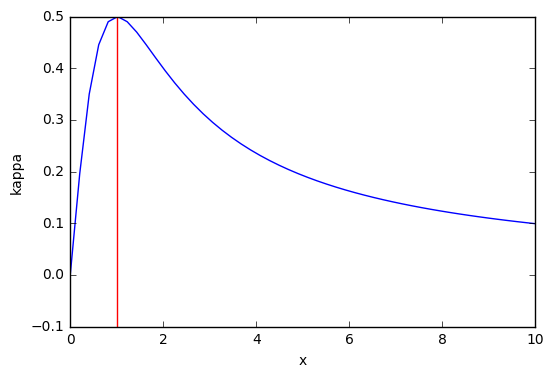

In [177]:
plt.plot(xs, ys, "b-", [gt,gt], [-0.1,0.5], "r-")
plt.xlabel('x')
plt.ylabel('kappa')
plt.savefig('/Users/cjb60/Desktop/kappa.pdf')

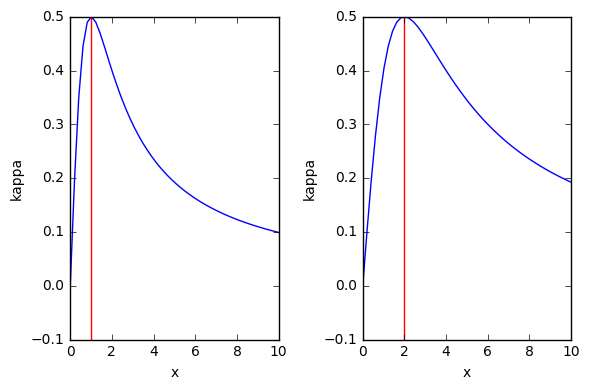

In [186]:
xs = np.linspace(0, 10, num=50)
for gt in [1,2]:
    ys = []
    for elem in xs:
        ys.append( float(kappa.eval({x:elem, y:gt})) )
    plt.subplot(1,2,gt)
    plt.plot(xs, ys, "b-", [gt,gt], [-0.1,0.5], "r-")
    plt.xlabel('x')
    plt.ylabel('kappa')
    plt.tight_layout()
plt.savefig('/Users/cjb60/Desktop/kappa_2part.pdf')

--------

In [18]:
x_ = T.dvector('x')
y_ = T.dvector('y')

#x_ = T.dmatrix('x')
#y_ = T.dmatrix('y')

In [44]:
num = 2*T.mean(x_*y_) - 2*T.mean(x_)*T.mean(y_)
den = T.mean(x_*x_) + T.mean(y_*y_) - 2*T.mean(x_)*T.mean(y_)

#num = T.dot(x_,y_) - T.mean(x_)*T.mean(y_)
#den = T.dot(x_,x_) + T.dot(y_,y_) - T.mean(x_)*T.mean(y_)

kp_ = T.log( 1 + (num / den) )

In [40]:
xtest=np.random.randint(0,5,size=(20,)).astype("float32")
ytest=np.random.randint(0,5,size=(20,)).astype("float32")
print xtest
print ytest

[ 2.  0.  4.  0.  2.  1.  1.  2.  3.  4.  0.  1.  4.  2.  1.  3.  0.  2.
  0.  1.]
[ 0.  2.  2.  1.  0.  3.  3.  4.  0.  2.  0.  2.  0.  3.  3.  1.  2.  2.
  2.  0.]


In [29]:
#xtest = np.asarray([1,2,0,1,2,3,1,0,2], dtype="float32")
#ytest = np.asarray([0.0,1.0,0.0,1.0,2.0,2.0,], dtype="float32")

In [46]:
np.exp(kp_.eval({x_:xtest, y_:ytest})) - 1

-0.14243323442136524

In [8]:
def weighted_kappa(human_rater, actual_rater, num_classes=5):
    assert len(human_rater) == len(actual_rater)
    def sum_matrix(X, Y):
        assert len(X) == len(Y)
        assert len(X[0]) == len(Y[0])
        sum = 0
        for i in range(0, len(X)):
            for j in range(0, len(X[0])):
                sum += X[i][j]*Y[i][j]
        return sum
    # compute W
    W = [ [float(0) for y in range(0, num_classes)] for x in range(0, num_classes) ]
    for i in range(0, num_classes):
        for j in range(0, num_classes):
            num = (i-j)**2
            den = (float(num_classes) - 1)**2
            W[i][j] = num # / den
    # compute O
    O = [ [float(0) for y in range(0, num_classes)] for x in range(0, num_classes) ]
    # rows = human_rater
    # cols = actual_rater
    for i in range(0, len(actual_rater)):
        O[ human_rater[i] ][ actual_rater[i] ] += 1
    # normalise O
    total = sum([sum(x) for x in O])
    for i in range(0, num_classes):
        for j in range(0, num_classes):
            O[i][j] = O[i][j] / total
    # compute E
    total = sum([sum(x) for x in O])
    E = [ [float(0) for y in range(0, num_classes)] for x in range(0, num_classes) ]
    for i in range(0, num_classes):
        for j in range(0, num_classes):
            # E_ij = row(i) total * col(j) total / total
            col_j = [ O[x][j] for x in range(0, len(O[0])) ]
            E[i][j] = sum(O[i]) * sum(col_j) / total
    # compute kappa
    kappa = 1 - (sum_matrix(W, O) / sum_matrix(W, E))
    return kappa


In [47]:
weighted_kappa(human_rater=xtest.astype("int32"), actual_rater=ytest.astype("int32"), num_classes=5)

-0.14243323442136502